In [1]:
# Import required libraries

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

sns.set_style("whitegrid")
plt.rcParams["figure.figsize"] = (8,5)

In [2]:
# Load datasets and keep raw backup copies

raw_sentiment = pd.read_csv("../data/fear_greed_index.csv")
raw_trades = pd.read_csv("../data/historical_data.csv")

sentiment = raw_sentiment.copy()
trades = raw_trades.copy()

In [3]:
# Inspect datasets structure and data types

sentiment.head()
trades.head()

sentiment.info()
trades.info()

<class 'pandas.DataFrame'>
RangeIndex: 2644 entries, 0 to 2643
Data columns (total 4 columns):
 #   Column          Non-Null Count  Dtype
---  ------          --------------  -----
 0   timestamp       2644 non-null   int64
 1   value           2644 non-null   int64
 2   classification  2644 non-null   str  
 3   date            2644 non-null   str  
dtypes: int64(2), str(2)
memory usage: 82.8 KB
<class 'pandas.DataFrame'>
RangeIndex: 211224 entries, 0 to 211223
Data columns (total 16 columns):
 #   Column            Non-Null Count   Dtype  
---  ------            --------------   -----  
 0   Account           211224 non-null  str    
 1   Coin              211224 non-null  str    
 2   Execution Price   211224 non-null  float64
 3   Size Tokens       211224 non-null  float64
 4   Size USD          211224 non-null  float64
 5   Side              211224 non-null  str    
 6   Timestamp IST     211224 non-null  str    
 7   Start Position    211224 non-null  float64
 8   Direction      

In [4]:
# Clean column names by removing extra spaces

sentiment.columns = sentiment.columns.str.strip()
trades.columns = trades.columns.str.strip()

In [5]:
# Rename important columns for easier analysis

trades.rename(columns={
    'Closed PnL': 'closedPnL',
    'Size Tokens': 'size_tokens',
    'Size USD': 'size_usd'
}, inplace=True)

In [6]:
# Convert Timestamp IST into datetime format

trades['time'] = pd.to_datetime(
    trades['Timestamp IST'],
    dayfirst=True
)

In [7]:
# Extract date for daily level analysis

trades['date'] = trades['time'].dt.date

In [8]:
# Remove unused timestamp columns

trades.drop(columns=['Timestamp IST', 'Timestamp'], inplace=True)

In [18]:
# Convert sentiment date column into datetime (handle mixed formats)

sentiment['date'] = pd.to_datetime(
    sentiment['date'],
    format='mixed',
    dayfirst=True,
    errors='coerce'
).dt.date

In [24]:
# Merge trader data with market sentiment

merged = trades.merge(
    sentiment[['date', 'classification']],
    on='date',
    how='left'
)

merged.rename(columns={'classification': 'sentiment'}, inplace=True)

In [25]:
# Verify merge success

merged['sentiment'].value_counts(dropna=False)

sentiment
Greed            48492
Fear             47315
NaN              43367
Extreme Greed    34393
Neutral          32246
Extreme Fear      5411
Name: count, dtype: int64

In [26]:
# Create win/loss indicator

merged['win'] = merged['closedPnL'] > 0

In [27]:
# Calculate daily PnL per trader

daily_pnl = (
    merged.groupby(['Account', 'date'])['closedPnL']
    .sum()
    .reset_index()
)

In [28]:
# Calculate win rate per trader

win_rate = (
    merged.groupby('Account')['win']
    .mean()
    .reset_index(name='win_rate')
)

In [29]:
# Calculate number of trades per day

trades_per_day = (
    merged.groupby('date')
    .size()
    .reset_index(name='trade_count')
)

In [30]:
# Compare long vs short behavior across sentiment

pd.crosstab(
    merged['sentiment'],
    merged['Side'],
    normalize='index'
)

Side,BUY,SELL
sentiment,,
Extreme Fear,0.460359,0.539641
Extreme Greed,0.439392,0.560608
Fear,0.500497,0.499503
Greed,0.497567,0.502433
Neutral,0.485735,0.514265


In [32]:
# Remove rows where sentiment is missing

merged_clean = merged.dropna(subset=['sentiment'])

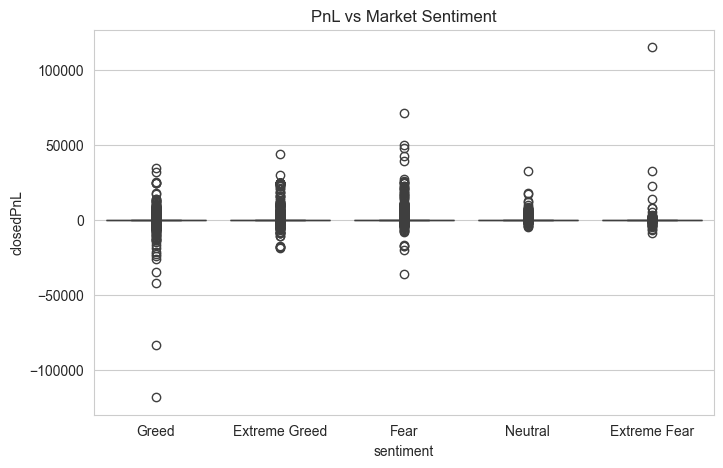

In [38]:
# Visualize PnL distribution by market sentiment and save figure correctly

fig, ax = plt.subplots()

sns.boxplot(
    data=merged_clean,
    x='sentiment',
    y='closedPnL',
    ax=ax
)

ax.set_title("PnL vs Market Sentiment")

# Save figure before displaying
fig.savefig("../outputs/pnl_vs_sentiment.png", dpi=300, bbox_inches='tight')

plt.show()

In [39]:
# Compare win rate between Fear and Greed days

merged.groupby('sentiment')['win'].mean()

sentiment
Extreme Fear     0.390501
Extreme Greed    0.458727
Fear             0.387890
Greed            0.403077
Neutral          0.402593
Name: win, dtype: float64

In [40]:
# Segment traders based on trading frequency

trade_counts = merged['Account'].value_counts()

merged['trader_type'] = merged['Account'].map(
    lambda x: 'Frequent' if trade_counts[x] > 50 else 'Rare'
)

In [41]:
# Save visualization output

plt.savefig("../outputs/pnl_vs_sentiment.png")

<Figure size 800x500 with 0 Axes>